# <b>Proyecto programación 07MIAR 2023</b>

## <b>Autores:</b> Diocles Germán Avendaño Ponces y Gonzalo Rama

## <b>Tema:</b> Deep Vision in classification tasks

## <b>0. Importación de librerías y preparación de ambiente</b>

In [5]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab o en local
!pip install - -upgrade - -force-reinstall - -no-deps kaggle


  Using cached kaggle-1.5.16-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


#### <b>0.1. Importamos librerías</b>

In [5]:
# import system libs
import warnings
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
# import Deep learning Libraries
# Ignore Warnings
warnings.filterwarnings("ignore")


### <b>0.2. Acciones necesarias para ejecutar el trabajo en local</b>

In [ ]:
# Directorio destino para el archivo kaggle.json
destination_directory = os.path.join(os.path.expanduser('~'), '.kaggle')

# Crear el directorio .kaggle si no existe
os.makedirs(destination_directory, exist_ok=True)

# Copiar el archivo kaggle.json al directorio .kaggle
shutil.copy('kaggle.json', destination_directory)

# Cambiar los permisos del archivo a lectura y escritura solo para el propietario (necesario para la seguridad)
os.chmod(os.path.join(destination_directory, 'kaggle.json'), 0o600)


### <b>0.3. Acciones necesarias para ejecutar el trabajo en Colab</b>

In [ ]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
# Importaciones en COLAB
'''from google.colab import files
files.upload()'''

# Creamos un directorio en el que copiamos el fichero kaggle.json
'''!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json'''

### <b>0.4. Descarga y procesamiento del dataset</b>

In [ ]:
# Descarguemos un dataset de cierta competición
!kaggle datasets download - d gpiosenka/100-bird-species


In [ ]:
# Creemos un directorio para descomprimir los datos
!mkdir dataset


In [ ]:
# Descomprimimos los datos y los dejamos listos para trabajar
# Linux o Colab
#!unzip 100-bird-species.zip -d dataset


### <b>0.5. Conexión a Google Drive (solo para colab)</b>

In [10]:
# Conectamos con nuestro Google Drive
'''
from google.colab import drive
drive.mount('/content/drive')
'''
# Movemos el dataset a nuestro drive
#!mv dataset to drive/MyDrive/Colab_Notebooks/07MIAR_2023/Proyecto


"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

## <b>1. Procesamiento de data<b>

#### Ruta del Dataset

In [2]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
# BASE_FOLDER = "drive/MyDrive/Colab_Notebooks/07MIAR_2023/Proyecto/"

# Establezco una ruta absoluta a un directorio existente de mi local
BASE_FOLDER = "D:/Elementos/Main/Maestria/Asignaturas/Deep Learning/Actividades/Proyecto/07MIAR/dataset/"




### <b>1.1. Lectura de datos y almacenamiento en DataFrame</b>

### 1.1.1 Declaración de funciones de carga de datos

In [14]:
def load_data(folder):
    train_dir = BASE_FOLDER+folder
    filepaths = []
    labels = []

    folds = os.listdir(train_dir)
    for fold in folds:
        foldpath = os.path.join(train_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenación rutas de datos con etiquetas en un DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def load_data_from_directory(folder,shuffle):
    return tf.keras.preprocessing.image_dataset_from_directory(BASE_FOLDER + folder, batch_size=32, image_size=(224,224), shuffle=shuffle)

    
def file_verifier_data_classes(title, df, shuffle):
    print(f'\n{title}')
    return ImageDataGenerator().flow_from_dataframe(df, x_col='filepaths', y_col='labels', target_size=(242, 224), class_mode='categorical',
                                                    color_mode='rgb', shuffle=shuffle, batch_size=32)

### 1.1.2. Carga de conjuto de datos (entrenamiento, validación y prueba)

In [7]:
train_df = load_data('train')
valid_df = load_data('valid')
test_df = load_data('test')


In [8]:
# Columnas del Dataframe de entrenamiento
train_df


,filepaths,labels
0,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
1,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
2,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
3,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
4,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
...,...,...
84630,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
84631,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
84632,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
84633,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE


In [6]:
# Columnas del Dataframe de validación
valid_df


,filepaths,labels
0,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
1,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
2,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
3,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
4,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
...,...,...
2620,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
2621,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
2622,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
2623,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE


In [7]:
# Columnas del Dataframe de prueba
test_df


,filepaths,labels
0,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
1,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
2,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
3,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
4,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ABBOTTS BABBLER
...,...,...
2620,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
2621,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
2622,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE
2623,D:/Elementos/Main/Maestria/Asignaturas/Deep Le...,ZEBRA DOVE


In [15]:

train_gen = file_verifier_data_classes(
    'Imágenes de entrenamiento', train_df, True)
valid_gen = file_verifier_data_classes(
    'Imágenes de validación', valid_df, True)
test_gen = file_verifier_data_classes('Imágenes de prueba', test_df, False)


Imágenes de entrenamiento
Found 84635 validated image filenames belonging to 525 classes.

Imágenes de validación
Found 2625 validated image filenames belonging to 525 classes.

Imágenes de prueba
Found 2625 validated image filenames belonging to 525 classes.


### <b>1.2. Inspección del conjunto de datos</b>

In [16]:
for img_batch,img_label in train_gen:
    print(img_batch.shape)
    print(img_label.shape)
    break

(32, 242, 224, 3)
(32, 525)


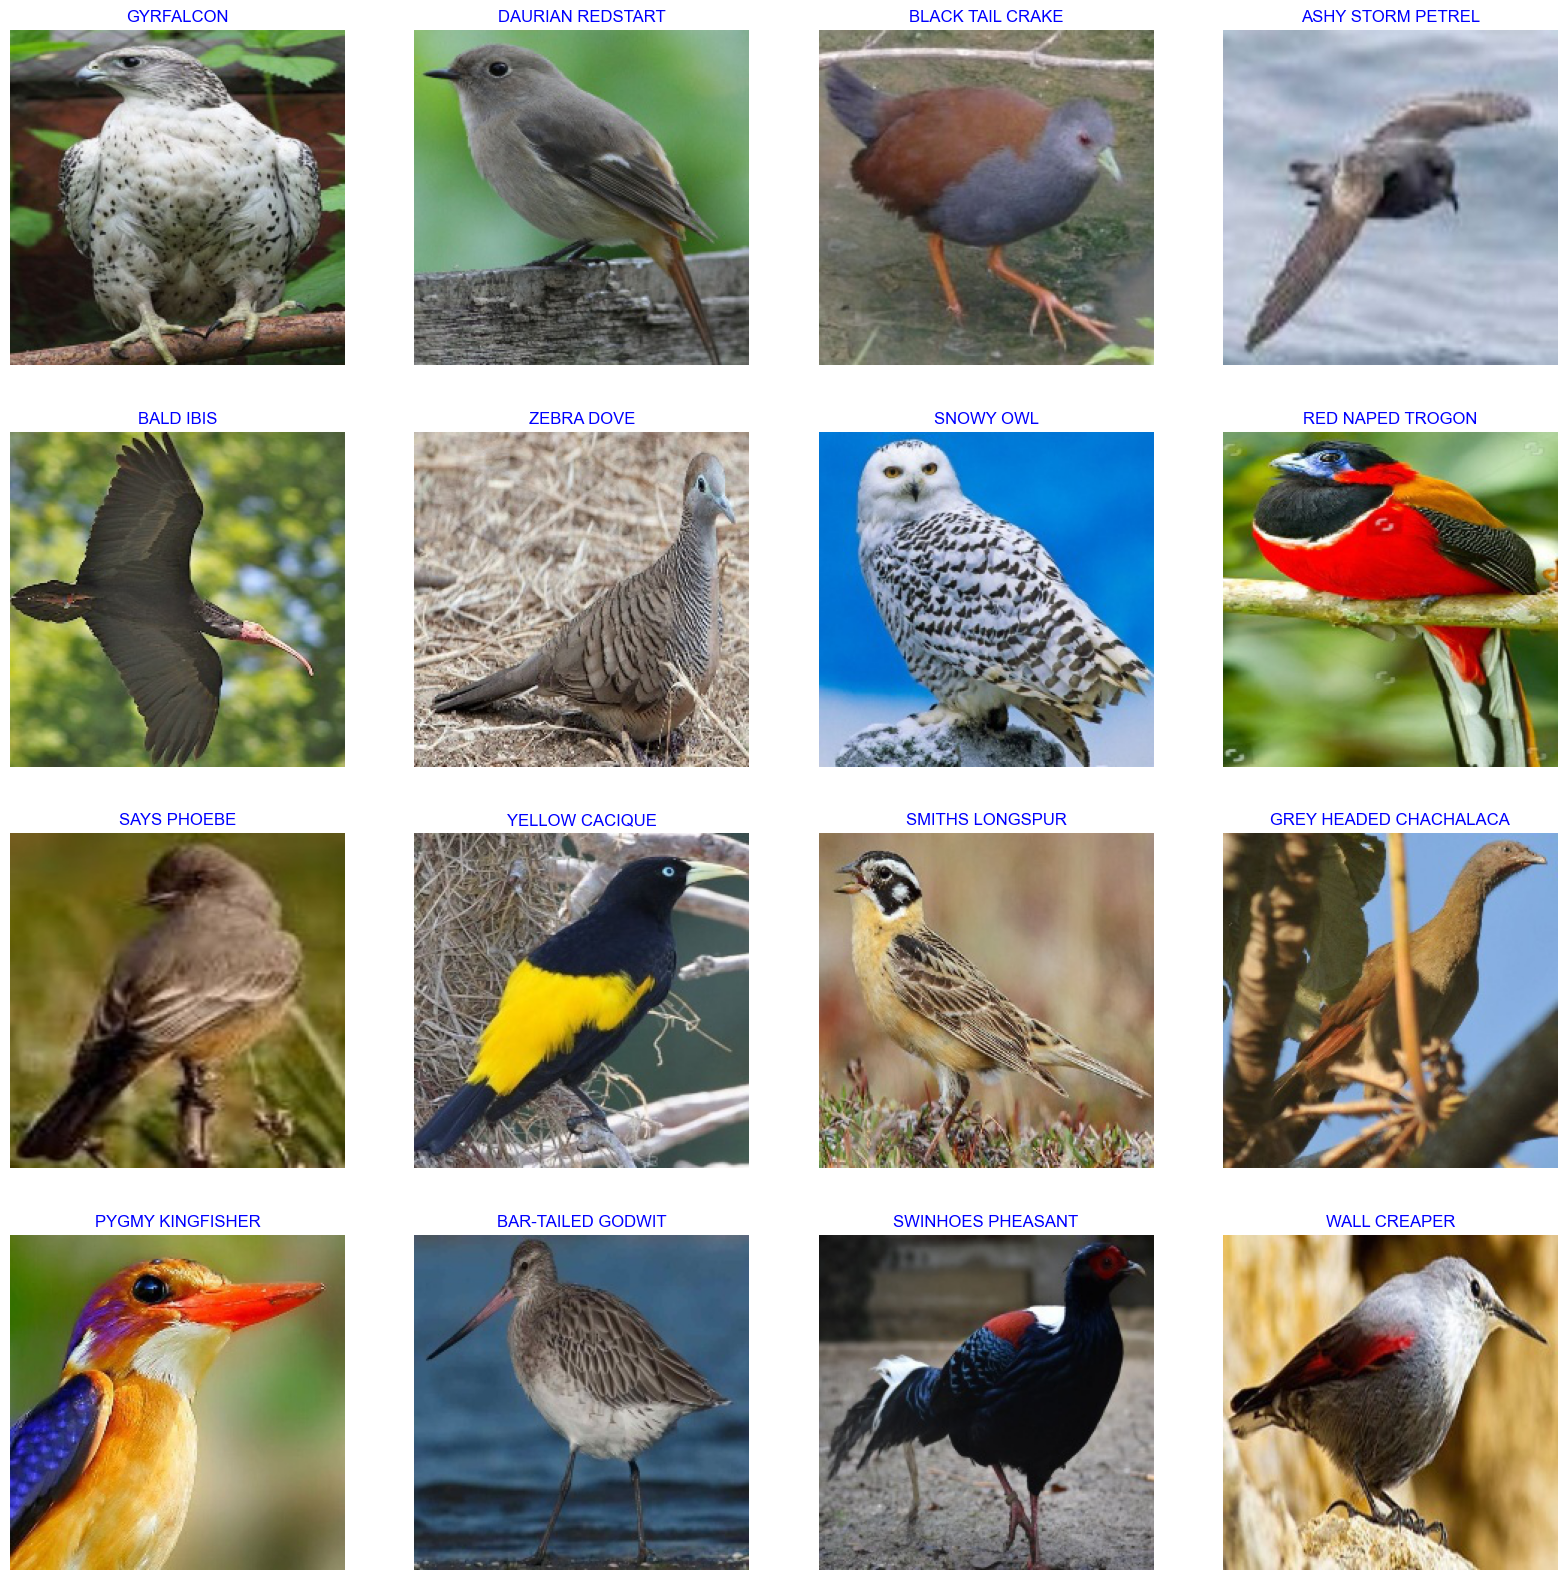

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
# defines list of dictionary's kays (classes), classes names : string
classes = list(g_dict.keys())
# get a batch size samples from the generator
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

## <b>2. Análisis y selección de arquitectura CNN</b>

Se realizó una investigación para saber cuales son las arquitecturas CNN de clasificación multiclase con imágenes más usadas y con mejores resultados, con el fin de delimitar las arquitectura a probar y seleccionar para el presente trabajo.
<br>Según <b>[1]</b> en su trabajo tituloado "Consecutive multiscale feature learning-based image classification model" las siguientes arquitecturas son las que más destacan:

1. Residual Networks (ResNets): Estas redes son una de las primeras y más poderosas arquitecturas de CNN basadas en aprendizaje profundo para la clasificación de imágenes. Se destacan por reformular las capas para aprender funciones residuales en relación con las entradas de las capas, lo que facilita la optimización y mejora la precisión gracias a la profundidad aumentada de la red​​.

2. Dense Convolutional Network (DenseNet): Esta red conecta cada capa con todas las demás en una propagación hacia adelante, lo que le permite manejar el problema del gradiente desvaneciente, asegurar el intercambio de características y reducir significativamente el número de parámetros entrenables​​.

3. ShuffleNet: Junto con MobileNet y MnasNet, ShuffleNet es uno de los modelos de clasificación más ampliamente empleados en dispositivos con potencia computacional limitada debido a su eficiencia y bajo requisito de memoria. Utiliza la convolución de grupos y la mezcla de canales para reducir significativamente los gastos computacionales mientras mantiene una precisión competitiva​​.

Como da a conocer <b>[1]</b> esta arquitecturas se destacan por su eficiencia y capacidad para manejar diversas tareas de clasificación de imágenes, lo que las convierte en opciones populares en la comunidad de visión por computadora

D:/Elementos/Main/Maestria/Asignaturas/Deep Learning/Actividades/Proyecto/07MIAR/src/dataset/test/WHIMBREL/1.jpg


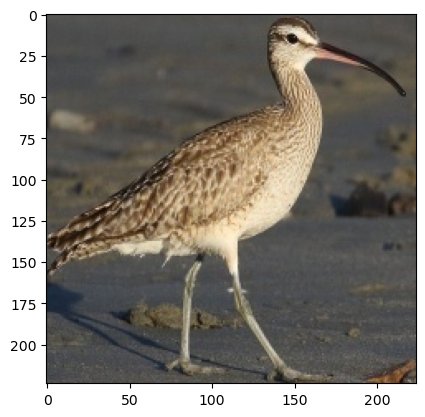

# <b>Bibliografía</b>

<b>[1]</b> Olimov, B., Subramanian, B., Ugli, R. A. A., Kim, J.-S., & Kim, J. (2023). Consecutive multiscale feature learning-based image classification model. Scientific Reports, 13(1). https://doi.org/10.1038/s41598-023-30480-8
